In [9]:
import time
import os
import random
import warnings
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from data_cleaning import data_cleaning
from data_loader import feature_extraction_dataloader

test_size = 0.15
seed = 9
num_trees = 100
scoring = "accuracy"

## Cleaning data (no need to do if no new data is added)

In [ ]:
data_cleaning()

In [3]:
warnings.filterwarnings('ignore')
loader = feature_extraction_dataloader()
loader.write_data(rgb=False)

[STATUS] Characters including ['aika_granzchesta', 'aisaka_taiga', 'akihime_sumomo', 'akiyama_mio', 'akizuki_ritsuko', 'alice_margatroid', 'allen_walker', 'amami_haruka', 'ana_coppola', 'andou_mahoro', 'arcueid_brunestud', 'asagiri_mai', 'asahina_mikuru', 'asakura_otome', 'asakura_yume', 'ayanami_rei', 'ayasaki_hayate', 'belldandy', 'black_rock_shooter', 'c.c', 'canal_volphied', 'caro_ru_lushe', 'chii', 'cirno', 'corticarte_apa_lagranges', 'daidouji_tomoyo', 'enma_ai', 'erio_mondial', 'fate_testarossa', 'feena_fam_earthlight', 'flandre_scarlet', 'fujibayashi_kyou', 'fukuzawa_yumi', 'furude_rika', 'furukawa_nagisa', 'fuyou_kaede', 'golden_darkness', 'hakurei_reimu', 'hatsune_miku', 'hayama_mizuki', 'hayase_mitsuki', 'hiiragi_kagami', 'hiiragi_tsukasa', 'hinamori_amu', 'hirasawa_yui', 'horo', 'houjou_reika', 'houjou_satoko', 'ibuki_fuuko', 'ichinose_kotomi', 'ikari_shinji', 'illyasviel_von_einzbern', 'ito_chika', 'ito_nobue', 'izayoi_sakuya', 'izumi_konata', 'kagamine_len', 'kagamine_rin

[STATUS] 108/178 processing folder: natsume_rin
[STATUS] 109/178 processing folder: nerine
[STATUS] 110/178 processing folder: nia
[STATUS] 111/178 processing folder: nijihara_ink
[STATUS] 112/178 processing folder: nogizaka_haruka
[STATUS] 113/178 processing folder: noumi_kudryavka
[STATUS] 114/178 processing folder: nunnally_lamperouge
[STATUS] 115/178 processing folder: ogasawara_sachiko
[STATUS] 116/178 processing folder: okazaki_tomoya
[STATUS] 117/178 processing folder: pastel_ink
[STATUS] 118/178 processing folder: patchouli_knowledge
[STATUS] 119/178 processing folder: primula
[STATUS] 120/178 processing folder: ranka_lee
[STATUS] 121/178 processing folder: reina
[STATUS] 122/178 processing folder: reinforce_zwei
[STATUS] 123/178 processing folder: reisen_udongein_inaba
[STATUS] 124/178 processing folder: remilia_scarlet
[STATUS] 125/178 processing folder: rider_medusa
[STATUS] 126/178 processing folder: rollo_lamperouge
[STATUS] 127/178 processing folder: ryougi_shiki
[STATUS]

### load saved data

In [4]:
data = sio.loadmat(os.path.join('data_set', 'img_feature.mat'))

### normalize data

In [5]:
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['image_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train test split

In [6]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (12909, 532)
Test data    : (2279, 532)
Train labels : (12909,)
Test labels  : (2279,)


### use cross validation to find out the performance of each model

[CROSS_VAL_SCORE] Training LR : accuracy: 0.268, std: 0.010
Training complete in 1m 22s
[CROSS_VAL_SCORE] Training LDA : accuracy: 0.259, std: 0.006
Training complete in 0m 3s
[CROSS_VAL_SCORE] Training KNN : accuracy: 0.223, std: 0.005
Training complete in 1m 32s
[CROSS_VAL_SCORE] Training CART : accuracy: 0.192, std: 0.012
Training complete in 0m 34s
[CROSS_VAL_SCORE] Training RF : accuracy: 0.442, std: 0.012
Training complete in 1m 33s
[CROSS_VAL_SCORE] Training NB : accuracy: 0.122, std: 0.001
Training complete in 0m 14s
[CROSS_VAL_SCORE] Training SVM : accuracy: 0.224, std: 0.005
Training complete in 4m 53s


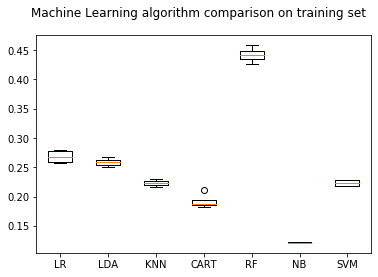

In [10]:
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.001, C=1, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed)}

results = []
names = []

for name in models.keys():
    since = time.time()
    model = models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Train the models and see the accuracy rate on both training and testing set

In [11]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[RESULT] LR accuracy on training set: 0.386
[RESULT] LR accuracy on testing set: 0.280
[TIME_CONSUMPTION] Finishing in 0m 32s
[RESULT] LDA accuracy on training set: 0.403
[RESULT] LDA accuracy on testing set: 0.262
[TIME_CONSUMPTION] Finishing in 0m 1s
[RESULT] KNN accuracy on training set: 0.468
[RESULT] KNN accuracy on testing set: 0.224
[TIME_CONSUMPTION] Finishing in 2m 15s
[RESULT] CART accuracy on training set: 0.997
[RESULT] CART accuracy on testing set: 0.192
[TIME_CONSUMPTION] Finishing in 0m 11s
[RESULT] RF accuracy on training set: 0.997
[RESULT] RF accuracy on testing set: 0.458
[TIME_CONSUMPTION] Finishing in 0m 32s
[RESULT] NB accuracy on training set: 0.378
[RESULT] NB accuracy on testing set: 0.111
[TIME_CONSUMPTION] Finishing in 0m 16s
[RESULT] SVM accuracy on training set: 0.340
[RESULT] SVM accuracy on testing set: 0.245
[TIME_CONSUMPTION] Finishing in 3m 21s


### Best model: Random Froest
We build some examples using random forest model.

In [ ]:
best_model = models['RF']

modeling_data_path = os.path.join('data_set', 'modeling_data')
characters_folders = os.listdir(modeling_data_path)
for character in characters_folders:
    pic_folder = os.path.join(modeling_data_path, character)
    all_pics = os.listdir(pic_folder)
    sampling = random.choices(all_pics, k=2)
    for pic in sampling:
        pic_dir = os.path.join(pic_folder, pic)
        image = cv2.imread(pic_dir)
        display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pic_feature = loader.extract_single_image(pic_dir)
        pic_feature = normalizer.transform(np.array([pic_feature]))
        # print(pic_feature.shape)
        pred_result = best_model.predict(pic_feature)[0]
        pred_result = name_label_map[pred_result]
        # print(pred_result)
        plt.imshow(display_image)
        plt.title("Prediction: {}, Truth: {}".format(pred_result, character))
        plt.show()

### Confusion Matrix

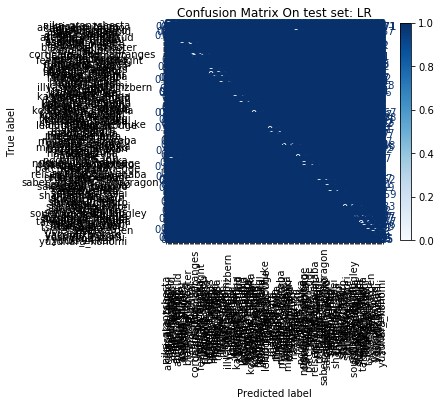

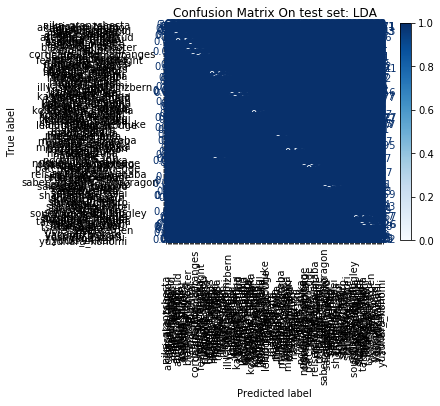

KeyboardInterrupt: 

In [12]:
for key in models.keys():
    model = models[key]
    disp = plot_confusion_matrix(model, fv_tst, fv_l_tst,
                                 display_labels=name_label_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.xticks(rotation='vertical', horizontalalignment="center")
    disp.ax_.set_title("Confusion Matrix On test set: {}".format(key))
    plt.show()